<a href="https://colab.research.google.com/github/Tanbhi-Akhtar/Comparison-of-deep-learning-algorithms-in-prediction-of-Diabetic-Retinopathy/blob/APTOS-dataset/aptosresnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
print ('modules loaded')

modules loaded


In [ ]:
#Generate data paths with labels
data_dir = '/content/drive/MyDrive/project 7thsem/colored_images/images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    # skip export.pkl file
    if pathlib.Path(foldpath).suffix == '':
        filelist = os.listdir(foldpath)

        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
#Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2929 validated image filenames belonging to 5 classes.
Found 439 validated image filenames belonging to 5 classes.
Found 294 validated image filenames belonging to 5 classes.


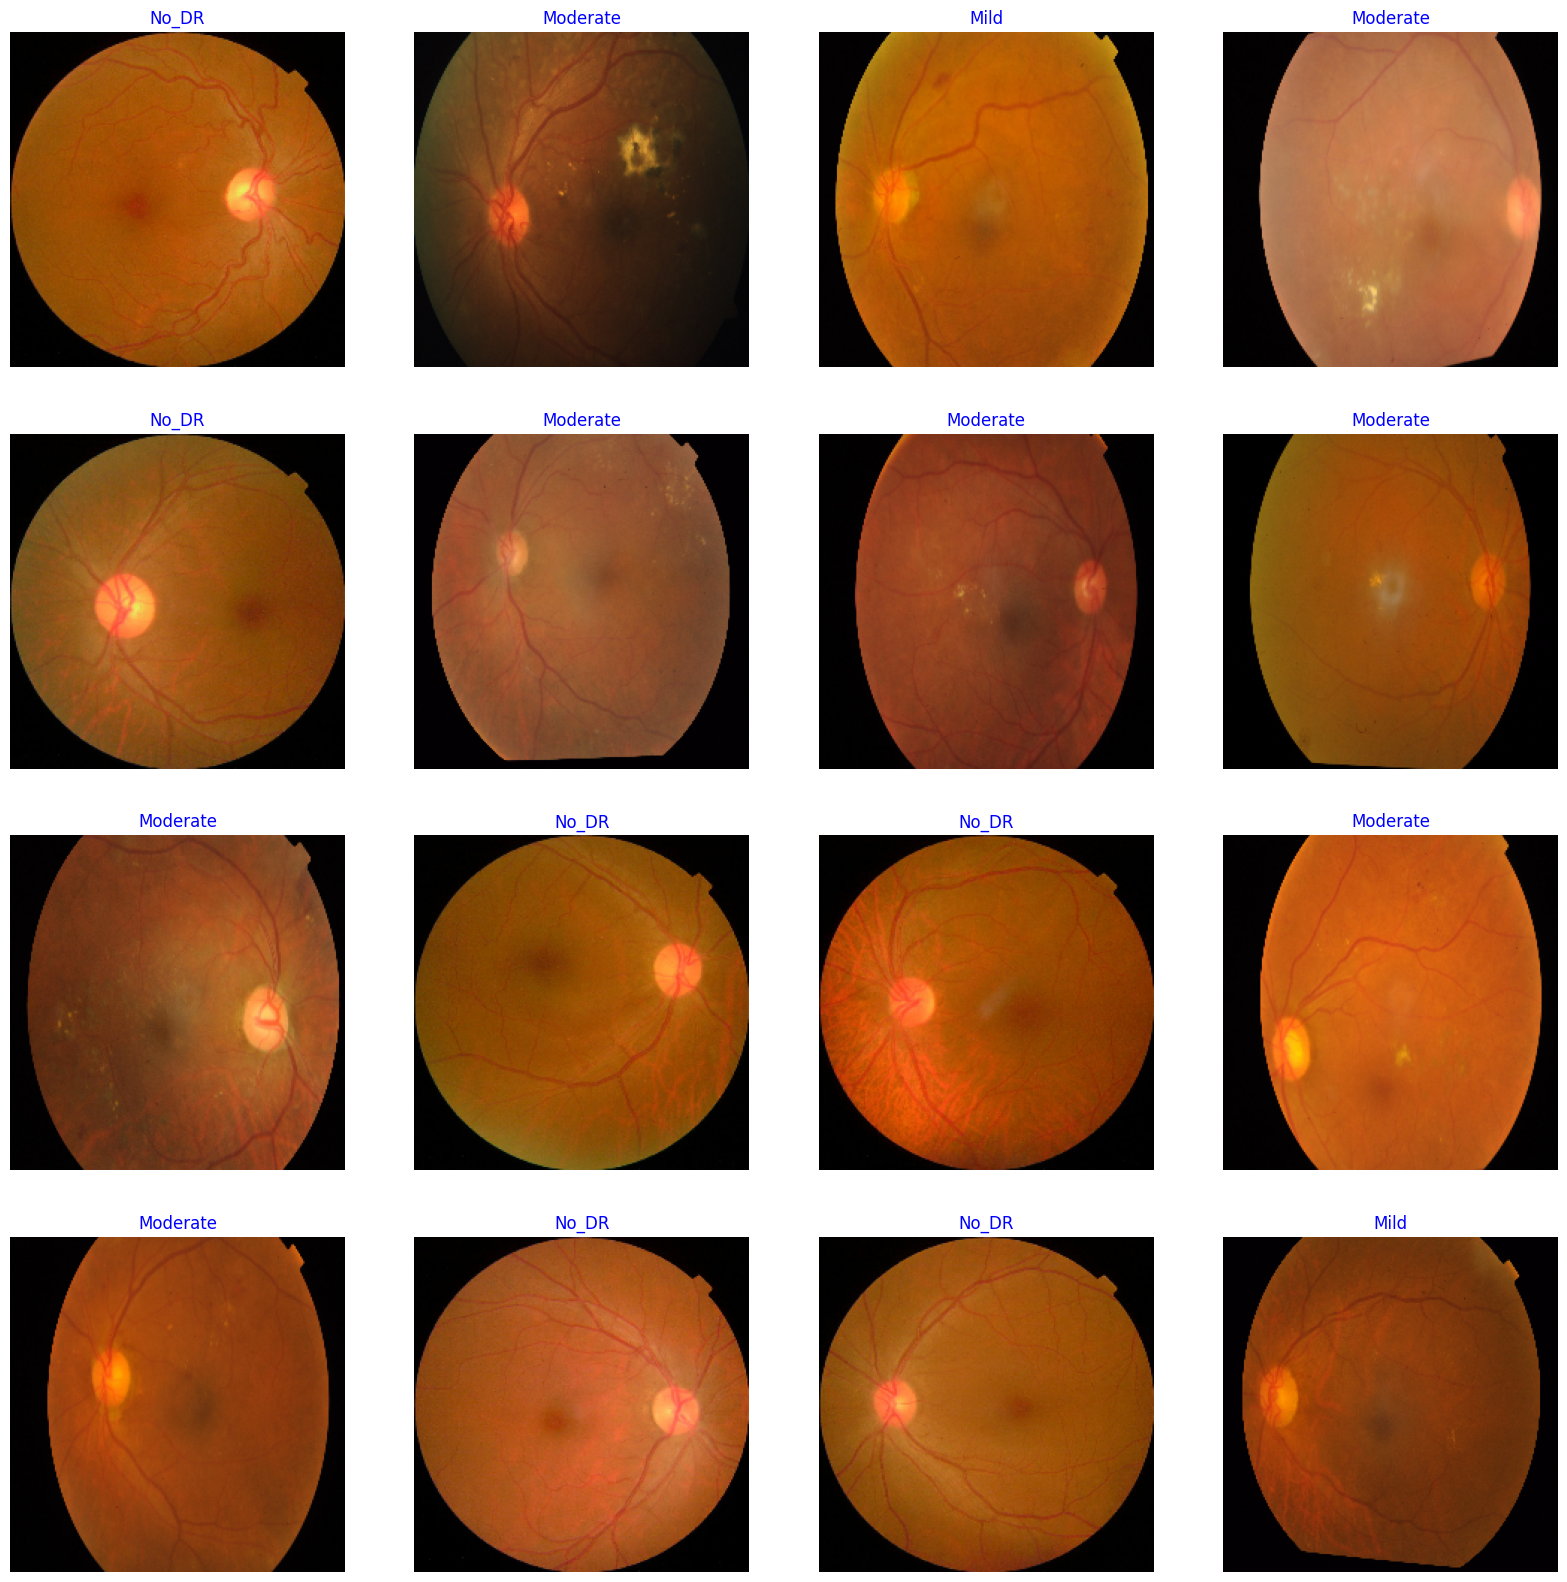

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Assuming train_gen is defined

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 24121733 (92.02 MB)
Trainable params: 24064517 (91.80 MB)
Non-trainable params: 57216 (223.50 KB)
__________

In [ ]:
epochs =35    #number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/35
184/184 [==============================] - 85s 225ms/step - loss: 4.7450 - accuracy: 0.6856 - val_loss: 2.6065 - val_accuracy: 0.7585
Epoch 2/35
184/184 [==============================] - 37s 203ms/step - loss: 1.7299 - accuracy: 0.7443 - val_loss: 1.1396 - val_accuracy: 0.7677
Epoch 3/35
184/184 [==============================] - 37s 203ms/step - loss: 0.8379 - accuracy: 0.7586 - val_loss: 0.6277 - val_accuracy: 0.7608
Epoch 4/35
184/184 [==============================] - 38s 205ms/step - loss: 0.5385 - accuracy: 0.7743 - val_loss: 0.4834 - val_accuracy: 0.7472
Epoch 5/35
184/184 [==============================] - 37s 201ms/step - loss: 0.4219 - accuracy: 0.7992 - val_loss: 0.3900 - val_accuracy: 0.7768
Epoch 6/35
184/184 [==============================] - 37s 201ms/step - loss: 0.3549 - accuracy: 0.8320 - val_loss: 0.4922 - val_accuracy: 0.7631
Epoch 7/35
184/184 [==============================] - 37s 201ms/step - loss: 0.3196 - accuracy: 0.8412 - val_loss: 0.3215 - val_ac

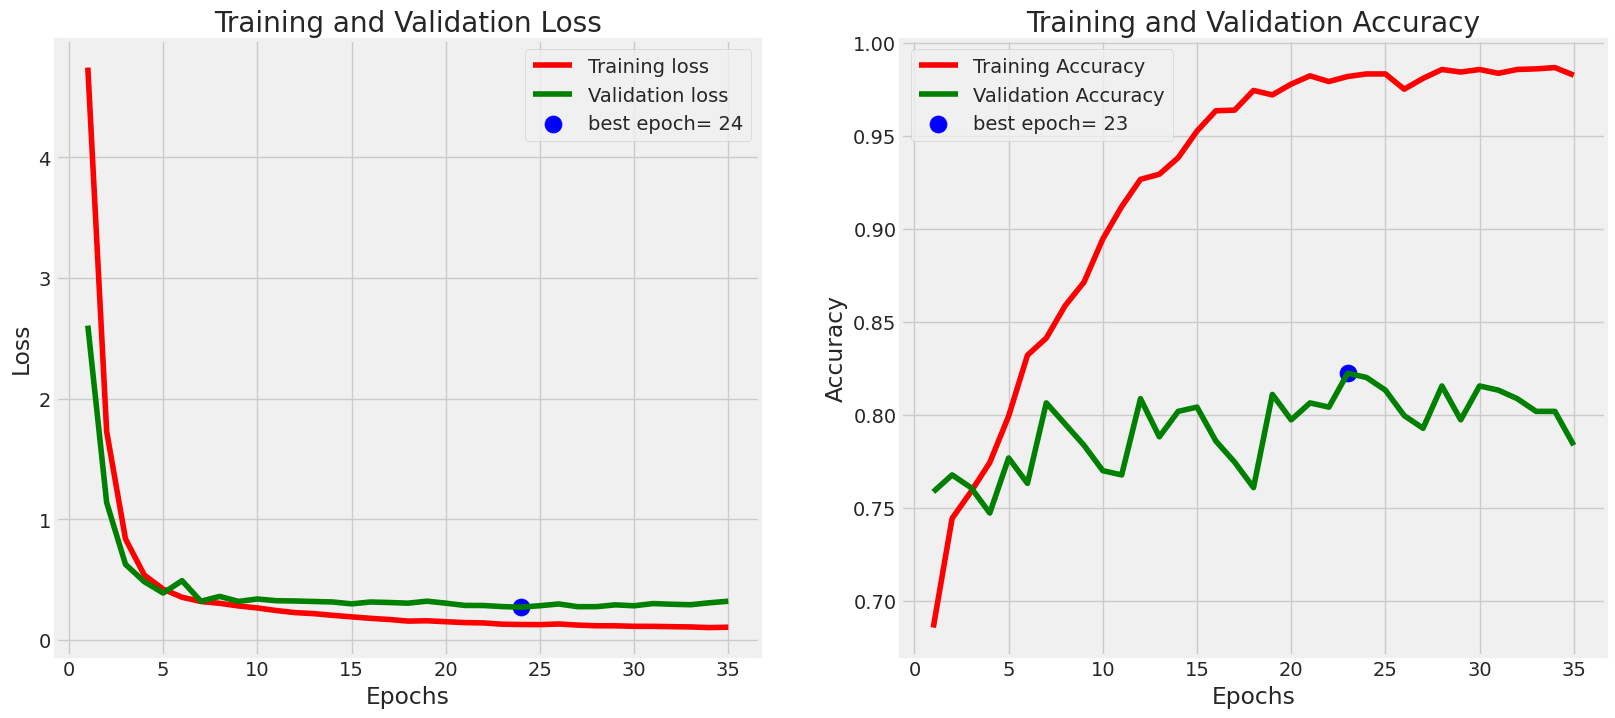

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

6/6 [==============================] - 0s 66ms/step - loss: 0.2727 - accuracy: 0.8333
Train Loss:  0.09120369702577591
Train Accuracy:  1.0
--------------------
Validation Loss:  0.293302446603775
Validation Accuracy:  0.8125
--------------------
Test Loss:  0.27272510528564453
Test Accuracy:  0.8333333134651184


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

AUC (class Mild): 0.9080870754022505
AUC (class Moderate): 0.904109589041096
AUC (class No_DR): 0.9937885319612478
AUC (class Proliferate_DR): 0.902200956937799
AUC (class Severe): 0.7279411764705882


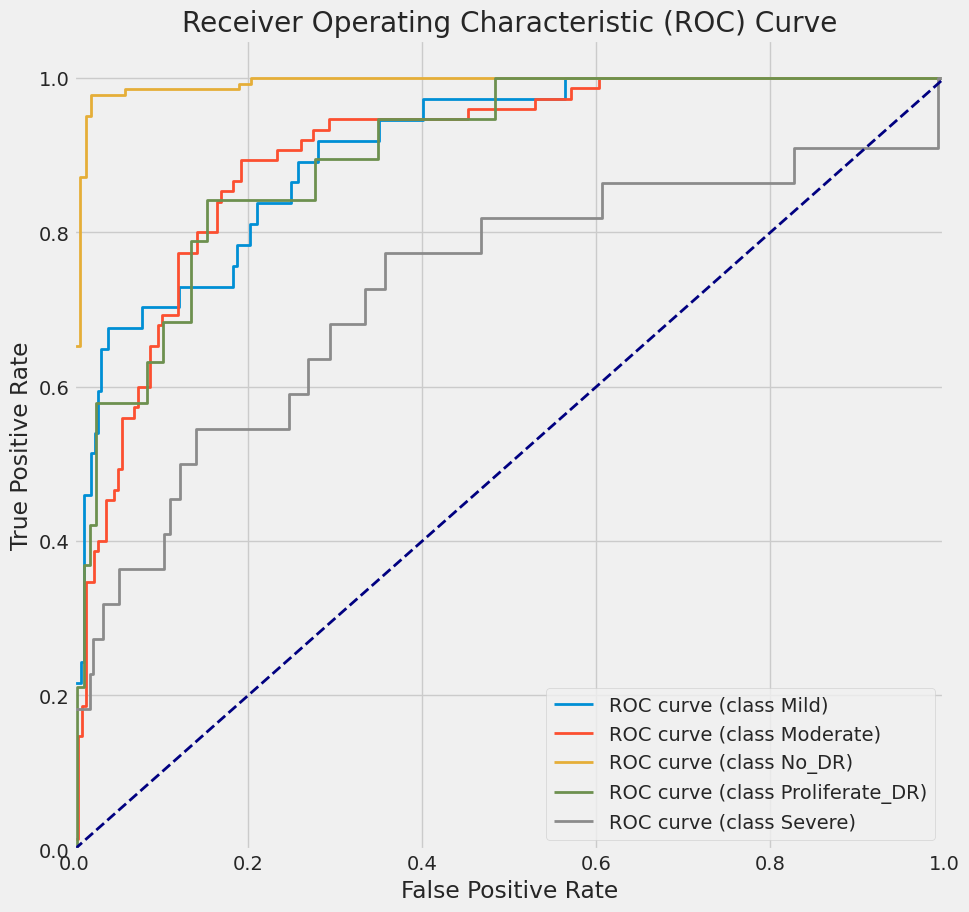

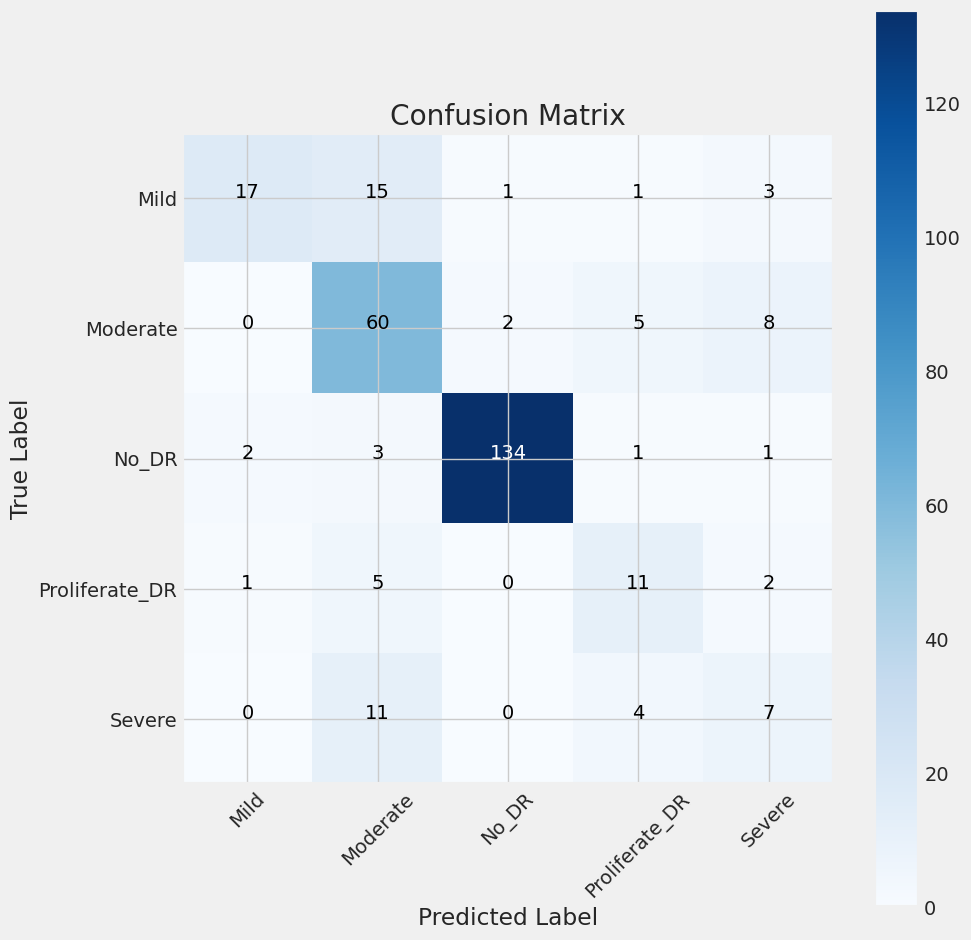

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import itertools

# Assuming 'y_pred_prob' contains the predicted probabilities for each class
# If 'y_pred_prob' contains class labels, you might need to convert them to probabilities using softmax or similar.

# Binarize the output
y_bin = label_binarize(test_gen.classes, classes=range(len(classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print AUC for each class
for i in range(len(classes)):
    print(f'AUC (class {classes[i]}): {roc_auc[i]}')

# Plot ROC curves
plt.figure(figsize=(10, 10))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {})'.format(classes[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Confusion matrix
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                precision    recall  f1-score   support

          Mild       0.85      0.46      0.60        37
      Moderate       0.64      0.80      0.71        75
         No_DR       0.98      0.95      0.96       141
Proliferate_DR       0.50      0.58      0.54        19
        Severe       0.33      0.32      0.33        22

      accuracy                           0.78       294
     macro avg       0.66      0.62      0.63       294
  weighted avg       0.80      0.78      0.78       294

